## 1. Import libraries and preprocess dataset

Download [`fashion-mnist` dataset from kaggle](https://www.kaggle.com/zalando-research/fashionmnist)

Credits: [@sayakdasgupta](https://www.kaggle.com/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset/)

In [1]:
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
import tensorflow as tf
import numpy as np
import pandas as pd

dataset = pd.read_csv('fashion-mnist/fashion-mnist_train.csv')

# Drop labels
x_train = dataset.drop('label',axis=1)
x_train = x_train.values
x_train = x_train.reshape(-1, 28, 28, 1)

dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


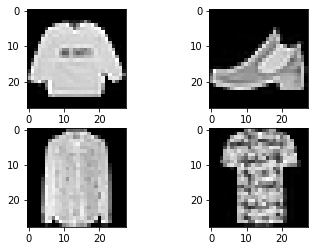

In [2]:
import matplotlib.pyplot as plt

# Display samples
fig, axe = plt.subplots(2,2)
index = 0

for i in range(2):
    for j in range(2):
        axe[i,j].imshow(x_train[index].reshape(28, 28), cmap='gray')
        index+=1

In [3]:
# Normalize dataset
x_train = x_train.astype('float32')
x_train = x_train / 255
x_train = x_train * 2 - 1.

print(f'Range: {x_train.min()} - {x_train.max()}')

Range: -1.0 - 1.0


## 2. Creating the GAN model

<img src="https://media-exp1.licdn.com/dms/image/C4E12AQG-Zmuf0s_FCQ/article-inline_image-shrink_1000_1488/0/1578476586340?e=1631145600&v=beta&t=59Vme2GrZpZhi2-KUznt2meYciR_V9qpp_EP8yZFaW8" width="300" height="auto" />

(Source: [Omer Faruk Kurt, 2020](https://www.linkedin.com/pulse/son-10-y%C4%B1ldaki-%C3%B6nemli-yapay-zeka-geli%C5%9Fmeleri-%C3%B6mer-faruk-kurt/?originalSubdomain=tr))

The idea is to use two neural networks, pitting one against the other (thus the "adversarial"), in order to generate new, synthetic instances of data that can pass for real data. They are used widely in image generation, video generation and voice generation.

It is made up of 2 components, the **Generator** that generates new data instances, and the **Discriminator** that tries to distinguish the generated/fake data from the real dataset.

The Discriminator algorithm tries to classify the input data, and predict the label or category the data belongs. They are concerned soley with the correlation. The Generator algorithm does the opposite, it simply attempts to predict features based on a given label.

<img src="https://miro.medium.com/max/2000/1*CkMMefLPqcEKPuuPLZY2_A.png" width="450" height="auto" />

(Source: [Joseph Rocca, 2019](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29))

The Generator network is fed noise (e.g. random distribution) generates fake data from the noise before it is inputted to the Discrimator.

## 2a. Create Generator model

In [4]:
gen_model = Sequential()
gen_model.add(Dense(512,input_shape=[100]))
gen_model.add(LeakyReLU(alpha=0.2))
gen_model.add(BatchNormalization(momentum=0.8))
gen_model.add(Dense(256))
gen_model.add(LeakyReLU(alpha=0.2))
gen_model.add(BatchNormalization(momentum=0.8))
gen_model.add(Dense(128))
gen_model.add(LeakyReLU(alpha=0.2))
gen_model.add(BatchNormalization(momentum=0.8))
gen_model.add(Dense(784))
gen_model.add(Reshape([28,28,1]))

## 2b. Create Discriminatory model

In [5]:
disc_model = Sequential()
disc_model.add(Dense(1,input_shape=[28,28,1]))
disc_model.add(Flatten())
disc_model.add(Dense(256))
disc_model.add(LeakyReLU(alpha=0.2))
disc_model.add(Dropout(0.5))
disc_model.add(Dense(128))
disc_model.add(LeakyReLU(alpha=0.2))
disc_model.add(Dropout(0.5))
disc_model.add(Dense(64))
disc_model.add(LeakyReLU(alpha=0.2))
disc_model.add(Dropout(0.5))
disc_model.add(Dense(1, activation='sigmoid'))

## 2c. Compile the GAN model

In [6]:
model = Sequential([gen_model, disc_model])

disc_model.compile(optimizer='adam', loss='binary_crossentropy')
# Freeze the convolutional base before compiling and train the model - essentially not setting the weights
disc_model.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy')

## 2d. Training the GAN model

1. **Phase 1**: Generator is fed random data, and creates some random images given to the Discriminator, which then takes classifies these fake noises using the random images and actual iamges. The difference between the predicted and actual results are backpropagated through the network and the weights of the Disciminator is updated (note that the Generator is not trained or updated in this phase).

2. **Phase 2**: The produced fake images are then given to the Discrimator again and this time, real images are not given for comparison. The Generator learns by tricking the Discriminator into outputting false positives, and the Discriminator outputs probabilities which are assessed against the actual results and the weights updated from the prior backpropagation (note that the Discrimanator is not trained or updated in this phase).

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/04/Example-of-the-Generative-Adversarial-Network-Model-Architecture.png" width="300" height="auto" />

(Source: [Jason Brownlee, 2019](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/))

> [training] drives the discriminator to attempt to learn to correctly classify samples as real or fake. Simultaneously, the generator attempts to fool the classifier into believing its samples are real. At convergence, the generator’s samples are indistinguishable from real data, and the discriminator outputs 1/2 everywhere. The discriminator may then be discarded.

(Source: [Deep Learning, Page 700, 2016](https://amzn.to/2YuwVjL))

Epoch 1
-- Batch 1 of 60
      Disc. Loss (real): 0.32875823974609375
      Disc. Loss (fake): 0.2800460159778595
      Loss: 2.517651319503784

-- Batch 21 of 60
      Disc. Loss (real): 0.38441571593284607
      Disc. Loss (fake): 0.3881096839904785
      Loss: 2.6794660091400146

-- Batch 41 of 60
      Disc. Loss (real): 0.2768576145172119
      Disc. Loss (fake): 0.37981507182121277
      Loss: 2.862227439880371

-- Batch 60 of 60
      Disc. Loss (real): 0.12260552495718002
      Disc. Loss (fake): 0.09521494060754776
      Loss: 3.406921863555908



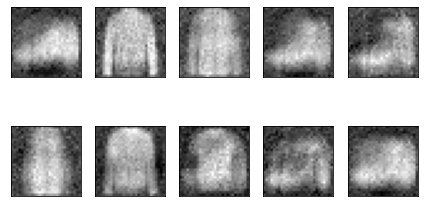

Epoch 2
-- Batch 1 of 60
      Disc. Loss (real): 0.12277968227863312
      Disc. Loss (fake): 0.11038334667682648
      Loss: 3.4273462295532227

-- Batch 21 of 60
      Disc. Loss (real): 0.619764506816864
      Disc. Loss (fake): 0.29627078771591187
      Loss: 2.7251391410827637

-- Batch 41 of 60
      Disc. Loss (real): 0.4436686336994171
      Disc. Loss (fake): 0.42421770095825195
      Loss: 1.4529064893722534

-- Batch 60 of 60
      Disc. Loss (real): 0.23505517840385437
      Disc. Loss (fake): 0.27469682693481445
      Loss: 3.305145740509033

Epoch 3
-- Batch 1 of 60
      Disc. Loss (real): 0.3187112510204315
      Disc. Loss (fake): 0.3232704699039459
      Loss: 3.2792954444885254

-- Batch 21 of 60
      Disc. Loss (real): 0.33208027482032776
      Disc. Loss (fake): 0.21745318174362183
      Loss: 4.371914863586426

-- Batch 41 of 60
      Disc. Loss (real): 0.37701547145843506
      Disc. Loss (fake): 0.39077410101890564
      Loss: 1.9269084930419922

-- Batch 60 o

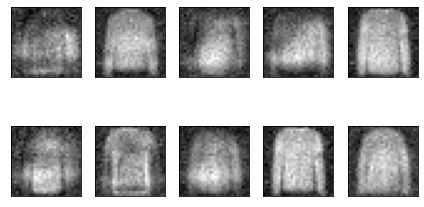

Epoch 6
-- Batch 1 of 60
      Disc. Loss (real): 0.24412091076374054
      Disc. Loss (fake): 0.1439303159713745
      Loss: 2.6538379192352295

-- Batch 21 of 60
      Disc. Loss (real): 0.6240322589874268
      Disc. Loss (fake): 0.5262750387191772
      Loss: 2.3972222805023193

-- Batch 41 of 60
      Disc. Loss (real): 0.3645320236682892
      Disc. Loss (fake): 0.4533533453941345
      Loss: 2.3070998191833496

-- Batch 60 of 60
      Disc. Loss (real): 0.3329896330833435
      Disc. Loss (fake): 0.3955361843109131
      Loss: 2.2030043601989746

Epoch 7
-- Batch 1 of 60
      Disc. Loss (real): 0.3891070783138275
      Disc. Loss (fake): 0.3787625730037689
      Loss: 2.073087453842163

-- Batch 21 of 60
      Disc. Loss (real): 0.3166563808917999
      Disc. Loss (fake): 0.25910139083862305
      Loss: 3.390878200531006

-- Batch 41 of 60
      Disc. Loss (real): 0.2474728524684906
      Disc. Loss (fake): 0.21879912912845612
      Loss: 2.6794273853302

-- Batch 60 of 60
    

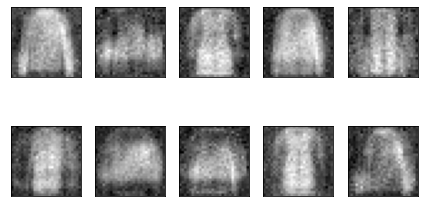

Epoch 10
-- Batch 1 of 60
      Disc. Loss (real): 0.34195059537887573
      Disc. Loss (fake): 0.32852283120155334
      Loss: 1.7981436252593994

-- Batch 21 of 60
      Disc. Loss (real): 0.4346356689929962
      Disc. Loss (fake): 0.27232709527015686
      Loss: 2.3813931941986084

-- Batch 41 of 60
      Disc. Loss (real): 0.47577741742134094
      Disc. Loss (fake): 0.43746575713157654
      Loss: 2.3425960540771484

-- Batch 60 of 60
      Disc. Loss (real): 0.39017724990844727
      Disc. Loss (fake): 0.4662902355194092
      Loss: 2.0451323986053467

Epoch 11
-- Batch 1 of 60
      Disc. Loss (real): 0.5214006900787354
      Disc. Loss (fake): 0.40696996450424194
      Loss: 2.030033588409424

-- Batch 21 of 60
      Disc. Loss (real): 0.2339790314435959
      Disc. Loss (fake): 0.15838105976581573
      Loss: 3.471071720123291

-- Batch 41 of 60
      Disc. Loss (real): 0.35325878858566284
      Disc. Loss (fake): 0.306488960981369
      Loss: 2.274782657623291

-- Batch 60 o

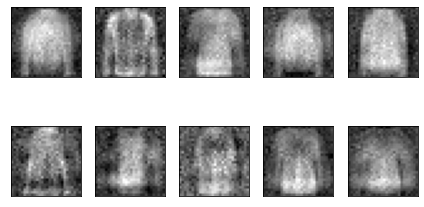

Epoch 14
-- Batch 1 of 60
      Disc. Loss (real): 0.29820874333381653
      Disc. Loss (fake): 0.28339114785194397
      Loss: 2.863999128341675

-- Batch 21 of 60
      Disc. Loss (real): 0.3610037863254547
      Disc. Loss (fake): 0.28895139694213867
      Loss: 2.0763559341430664

-- Batch 41 of 60
      Disc. Loss (real): 0.631111741065979
      Disc. Loss (fake): 0.39402690529823303
      Loss: 2.036684989929199

-- Batch 60 of 60
      Disc. Loss (real): 0.4270508885383606
      Disc. Loss (fake): 0.27379605174064636
      Loss: 2.887329339981079

Epoch 15
-- Batch 1 of 60
      Disc. Loss (real): 0.49980252981185913
      Disc. Loss (fake): 0.32690656185150146
      Loss: 2.7807552814483643

-- Batch 21 of 60
      Disc. Loss (real): 0.31644538044929504
      Disc. Loss (fake): 0.3242025077342987
      Loss: 1.8726274967193604

-- Batch 41 of 60
      Disc. Loss (real): 0.3694571852684021
      Disc. Loss (fake): 0.2723037004470825
      Loss: 2.83144474029541

-- Batch 60 of 6

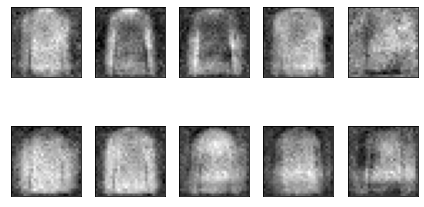

Epoch 18
-- Batch 1 of 60
      Disc. Loss (real): 0.41347160935401917
      Disc. Loss (fake): 0.3919900953769684
      Loss: 2.510275363922119

-- Batch 21 of 60
      Disc. Loss (real): 0.34604328870773315
      Disc. Loss (fake): 0.4279114902019501
      Loss: 2.473991632461548

-- Batch 41 of 60
      Disc. Loss (real): 0.21924473345279694
      Disc. Loss (fake): 0.2560006082057953
      Loss: 2.814321517944336

-- Batch 60 of 60
      Disc. Loss (real): 0.31153538823127747
      Disc. Loss (fake): 0.23777437210083008
      Loss: 3.3518788814544678

Epoch 19
-- Batch 1 of 60
      Disc. Loss (real): 0.2946096658706665
      Disc. Loss (fake): 0.21346737444400787
      Loss: 3.4183640480041504

-- Batch 21 of 60
      Disc. Loss (real): 0.28504690527915955
      Disc. Loss (fake): 0.20161639153957367
      Loss: 2.580193281173706

-- Batch 41 of 60
      Disc. Loss (real): 0.54012131690979
      Disc. Loss (fake): 0.3767754137516022
      Loss: 1.7293682098388672

-- Batch 60 of 6

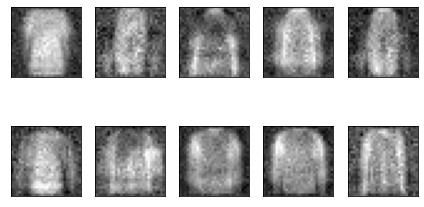

Epoch 22
-- Batch 1 of 60
      Disc. Loss (real): 0.5060480237007141
      Disc. Loss (fake): 0.43707624077796936
      Loss: 1.8076752424240112

-- Batch 21 of 60
      Disc. Loss (real): 0.28514614701271057
      Disc. Loss (fake): 0.27753356099128723
      Loss: 2.4792559146881104

-- Batch 41 of 60
      Disc. Loss (real): 0.3575872778892517
      Disc. Loss (fake): 0.3082638084888458
      Loss: 2.5911800861358643

-- Batch 60 of 60
      Disc. Loss (real): 0.28707513213157654
      Disc. Loss (fake): 0.3861709535121918
      Loss: 2.907609224319458

Epoch 23
-- Batch 1 of 60
      Disc. Loss (real): 0.3110772669315338
      Disc. Loss (fake): 0.40088292956352234
      Loss: 2.7581357955932617

-- Batch 21 of 60
      Disc. Loss (real): 0.23813031613826752
      Disc. Loss (fake): 0.2236560881137848
      Loss: 2.4295599460601807

-- Batch 41 of 60
      Disc. Loss (real): 0.39288318157196045
      Disc. Loss (fake): 0.2882579267024994
      Loss: 2.603017568588257

-- Batch 60 o

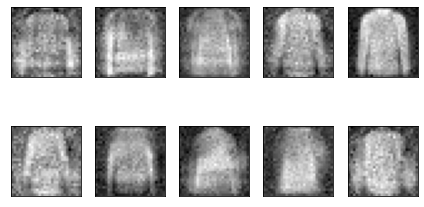

In [24]:
def GAN_train(data, epochs_n=150, batch_size=100, noise_shape=100, samples_n=10):
    for epoch in range(epochs_n):        
        print(f'Epoch {epoch+1}')

        batches_n = data.shape[0] // batch_size
        batch_errors = []

        for i in range(batches_n):
            # Training discriminator on real images
            train_data = data[i*batch_size : (i+1)*batch_size]
            train_label = np.ones(shape=(batch_size,1))
            disc_model.trainable = True
            d_loss_real = disc_model.train_on_batch(train_data, train_label)

            # Training discriminator on fake images            
            noise = np.random.normal(size=[batch_size, noise_shape])
            gen_image = gen_model.predict_on_batch(noise)
            train_label = np.zeros(shape=(batch_size,1))
            d_loss_fake = disc_model.train_on_batch(gen_image, train_label)

            # Training generator 
            train_label = np.ones(shape=(batch_size,1))

            # Turn off the discriminator training while training the generator
            disc_model.trainable = False 
            d_g_loss_batch = model.train_on_batch(noise, train_label)   

            if i % 20 == 0 or i == batches_n - 1:
                print(f"""-- Batch {i+1} of {batches_n}
      Disc. Loss (real): {d_loss_real}
      Disc. Loss (fake): {d_loss_fake}
      Loss: {d_g_loss_batch}
""")     
        # Display generated images after each 10 epoch interval
        if epoch % 4 == 0:
            x_fake = gen_model.predict(np.random.normal(loc=0, scale=1, size=(samples_n, 100)))

            for k in range(samples_n):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()

with tf.device('/gpu:0'):
    GAN_train(x_train, epochs_n=25, batch_size=1000)

## 2e. Predict using the GAN model

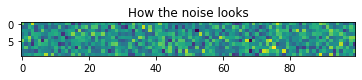

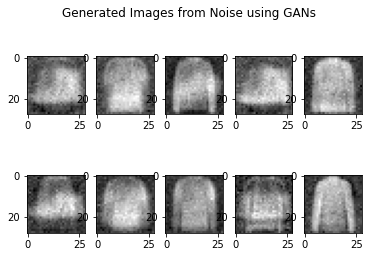

In [26]:
noise = np.random.normal(size=[10, 100])
gen_image = gen_model.predict(noise)

plt.imshow(noise)
plt.title('How the noise looks')

fig,axe = plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')

index = 0

for i in range(2):
    for j in range(5):
        axe[i,j].imshow(gen_image[index].reshape(28,28), cmap='gray')
        index+=1

## 3. Creating the Deep Convolution GAN (DCGAN)

<img src="https://editor.analyticsvidhya.com/uploads/51391generator_and_discriminator.png" width="400" height="auto" />

(Source: [GOURAV29, 2021](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29))

One common failure from GANs involves the Generator collapsing to produce only a single sample, which in this case, the Generator learns to trick the Discriminator with a single image or a few images to believe as real image. 

Another involves the generator and discriminator oscillating during training, rather than converging to a fixed point. If one agent becomes much more powerful than the other, the learning signal to the other agent becomes useless, and the system does not learn. 

One of the methods to improve such is to use Deep Convolution GAN.

## 3a. Create Generator model

In [45]:
gen_model = Sequential()
gen_model.add(Dense(7 * 7 * 128, input_shape=[100]))
gen_model.add(Reshape([7, 7, 128]))
gen_model.add(BatchNormalization())
# Use 64 instead. For quicker demo and run-through purposes 8 is used.
# The accuracy gets a dip due to lower number of filters.
gen_model.add(Conv2DTranspose(8, kernel_size=5, strides=2, padding='same', activation='relu'))
gen_model.add(BatchNormalization())
gen_model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'))

## 3b. Create Discriminator model

In [46]:
disc_model = Sequential()
# Use 64 instead. For quicker demo and run-through purposes 8 is used.
# The accuracy gets a dip due to lower number of filters.
disc_model.add(Conv2D(8, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.3), input_shape=[28, 28, 1])) # Original is 64
disc_model.add(Dropout(0.5))
# Use 128 instead. For quicker demo and run-through purposes 16 is used. 
# The accuracy gets a dip due to lower number of filters.
disc_model.add(Conv2D(16, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.3))) # Original is 128
disc_model.add(Dropout(0.5))
disc_model.add(Flatten())
disc_model.add(Dense(1, activation='sigmoid'))

## 3c. Compile the DCGAN model

In [47]:
model = Sequential([gen_model, disc_model])

disc_model.compile(optimizer='adam', loss='binary_crossentropy')
# Freeze the convolutional base before compiling and train the model - essentially not setting the weights
disc_model.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy')

## 3d. Training the DCGAN model

Epoch 1
-- Batch 1 of 20
      Disc. Loss (real): 0.020033111795783043
      Disc. Loss (fake): 0.7595009803771973
      Loss: 0.14409837126731873

-- Batch 20 of 20
      Disc. Loss (real): 0.043541569262742996
      Disc. Loss (fake): 0.31939277052879333
      Loss: 0.22861401736736298



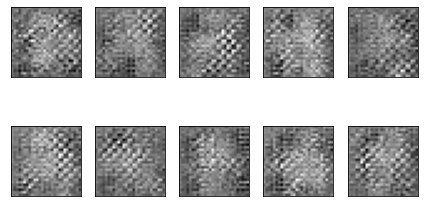

Epoch 2
-- Batch 1 of 20
      Disc. Loss (real): 0.04566120356321335
      Disc. Loss (fake): 0.2811199128627777
      Loss: 0.24778780341148376

-- Batch 20 of 20
      Disc. Loss (real): 0.07337266206741333
      Disc. Loss (fake): 0.1400316208600998
      Loss: 0.42714861035346985

Epoch 3
-- Batch 1 of 20
      Disc. Loss (real): 0.07326319068670273
      Disc. Loss (fake): 0.12977929413318634
      Loss: 0.4860062599182129

-- Batch 20 of 20
      Disc. Loss (real): 0.3056434392929077
      Disc. Loss (fake): 0.2644074559211731
      Loss: 0.09693267941474915

Epoch 4
-- Batch 1 of 20
      Disc. Loss (real): 0.30678167939186096
      Disc. Loss (fake): 0.2962019145488739
      Loss: 0.09740336239337921

-- Batch 20 of 20
      Disc. Loss (real): 0.771981418132782
      Disc. Loss (fake): 0.7626153230667114
      Loss: 0.42590680718421936

Epoch 5
-- Batch 1 of 20
      Disc. Loss (real): 0.7476681470870972
      Disc. Loss (fake): 0.7760053873062134
      Loss: 0.492713302373886

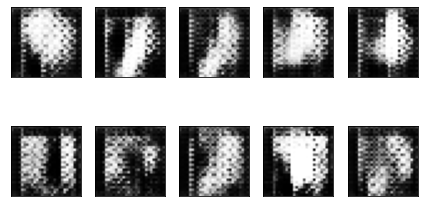

Epoch 6
-- Batch 1 of 20
      Disc. Loss (real): 0.6720625758171082
      Disc. Loss (fake): 0.6487715840339661
      Loss: 0.9798285961151123

-- Batch 20 of 20
      Disc. Loss (real): 0.5349360108375549
      Disc. Loss (fake): 0.5097001791000366
      Loss: 1.353115200996399

Epoch 7
-- Batch 1 of 20
      Disc. Loss (real): 0.5649433732032776
      Disc. Loss (fake): 0.529512345790863
      Loss: 1.3885676860809326

-- Batch 20 of 20
      Disc. Loss (real): 0.826086163520813
      Disc. Loss (fake): 0.8183647990226746
      Loss: 0.8915057182312012

Epoch 8
-- Batch 1 of 20
      Disc. Loss (real): 0.842136561870575
      Disc. Loss (fake): 0.8438117504119873
      Loss: 0.8855730891227722

-- Batch 20 of 20
      Disc. Loss (real): 0.7989612817764282
      Disc. Loss (fake): 0.8026265501976013
      Loss: 0.7922801971435547

Epoch 9
-- Batch 1 of 20
      Disc. Loss (real): 0.7941399812698364
      Disc. Loss (fake): 0.7960525155067444
      Loss: 0.809006929397583

-- Batch 20

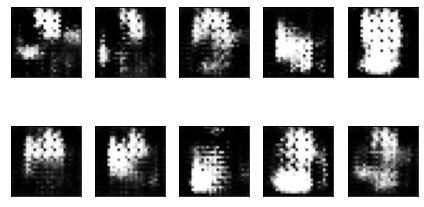

Epoch 10
-- Batch 1 of 20
      Disc. Loss (real): 0.648531973361969
      Disc. Loss (fake): 0.6363581418991089
      Loss: 0.9797109365463257

-- Batch 20 of 20
      Disc. Loss (real): 0.9410714507102966
      Disc. Loss (fake): 0.690234363079071
      Loss: 0.8777859807014465

Epoch 11
-- Batch 1 of 20
      Disc. Loss (real): 0.9301514625549316
      Disc. Loss (fake): 0.6856396198272705
      Loss: 0.8650018572807312

-- Batch 20 of 20
      Disc. Loss (real): 0.9070059657096863
      Disc. Loss (fake): 0.6447232365608215
      Loss: 0.8826923966407776

Epoch 12
-- Batch 1 of 20
      Disc. Loss (real): 0.8783226013183594
      Disc. Loss (fake): 0.6509470343589783
      Loss: 0.8830893635749817

-- Batch 20 of 20
      Disc. Loss (real): 0.7252452969551086
      Disc. Loss (fake): 0.5941706299781799
      Loss: 0.9817324280738831

Epoch 13
-- Batch 1 of 20
      Disc. Loss (real): 0.7066165208816528
      Disc. Loss (fake): 0.5891768932342529
      Loss: 0.9784842133522034

-- B

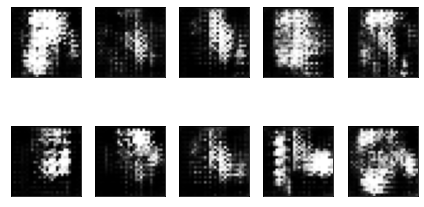

Epoch 14
-- Batch 1 of 20
      Disc. Loss (real): 0.7224481701850891
      Disc. Loss (fake): 0.7194404006004333
      Loss: 0.8204225301742554

-- Batch 20 of 20
      Disc. Loss (real): 0.6964124441146851
      Disc. Loss (fake): 0.7380902767181396
      Loss: 0.7124789953231812

Epoch 15
-- Batch 1 of 20
      Disc. Loss (real): 0.6816120147705078
      Disc. Loss (fake): 0.7328622937202454
      Loss: 0.7118240594863892

-- Batch 20 of 20
      Disc. Loss (real): 0.609544038772583
      Disc. Loss (fake): 0.5036231875419617
      Loss: 1.2321683168411255

Epoch 16
-- Batch 1 of 20
      Disc. Loss (real): 0.5989313721656799
      Disc. Loss (fake): 0.5852980613708496
      Loss: 1.1153947114944458

-- Batch 20 of 20
      Disc. Loss (real): 0.7874962687492371
      Disc. Loss (fake): 0.7001447677612305
      Loss: 0.7767006754875183

Epoch 17
-- Batch 1 of 20
      Disc. Loss (real): 0.7763227820396423
      Disc. Loss (fake): 0.6907392740249634
      Loss: 0.7878786325454712

-- 

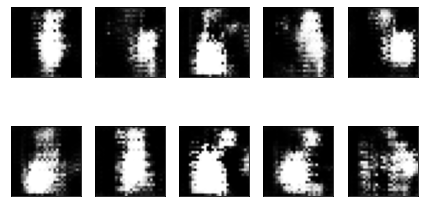

Epoch 18
-- Batch 1 of 20
      Disc. Loss (real): 0.6967533230781555
      Disc. Loss (fake): 0.6122779250144958
      Loss: 0.9040242433547974

-- Batch 20 of 20
      Disc. Loss (real): 0.6643521785736084
      Disc. Loss (fake): 0.6052215099334717
      Loss: 0.868088960647583

Epoch 19
-- Batch 1 of 20
      Disc. Loss (real): 0.6550031900405884
      Disc. Loss (fake): 0.6089776158332825
      Loss: 0.8664007186889648

-- Batch 20 of 20
      Disc. Loss (real): 0.7315780520439148
      Disc. Loss (fake): 0.6428492665290833
      Loss: 0.8006415963172913

Epoch 20
-- Batch 1 of 20
      Disc. Loss (real): 0.7261964678764343
      Disc. Loss (fake): 0.6366856098175049
      Loss: 0.8042230606079102

-- Batch 20 of 20
      Disc. Loss (real): 0.6739455461502075
      Disc. Loss (fake): 0.6499858498573303
      Loss: 0.8157013058662415

Epoch 21
-- Batch 1 of 20
      Disc. Loss (real): 0.6676563024520874
      Disc. Loss (fake): 0.6424862742424011
      Loss: 0.8194442391395569

-- 

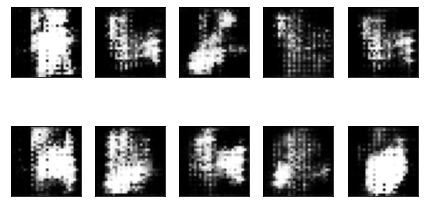

Epoch 22
-- Batch 1 of 20
      Disc. Loss (real): 0.6749909520149231
      Disc. Loss (fake): 0.7554047703742981
      Loss: 0.6662507653236389

-- Batch 20 of 20
      Disc. Loss (real): 0.7194778919219971
      Disc. Loss (fake): 0.7164259552955627
      Loss: 0.7328235507011414

Epoch 23
-- Batch 1 of 20
      Disc. Loss (real): 0.704433262348175
      Disc. Loss (fake): 0.724031925201416
      Loss: 0.7297597527503967

-- Batch 20 of 20
      Disc. Loss (real): 0.6921823024749756
      Disc. Loss (fake): 0.6777216792106628
      Loss: 0.7468663454055786

Epoch 24
-- Batch 1 of 20
      Disc. Loss (real): 0.6749597787857056
      Disc. Loss (fake): 0.6744515895843506
      Loss: 0.7482936382293701

-- Batch 20 of 20
      Disc. Loss (real): 0.7169386148452759
      Disc. Loss (fake): 0.7348782420158386
      Loss: 0.7401580214500427

Epoch 25
-- Batch 1 of 20
      Disc. Loss (real): 0.7241239547729492
      Disc. Loss (fake): 0.7423464059829712
      Loss: 0.7263749837875366

-- B

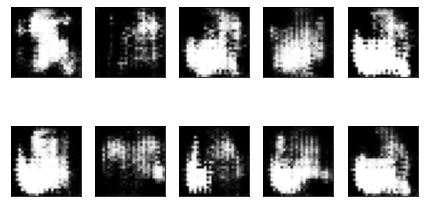

In [49]:
with tf.device('/gpu:0'):
    GAN_train(x_train, epochs_n=25, batch_size=3000)

## 3e. Predict using the GAN model

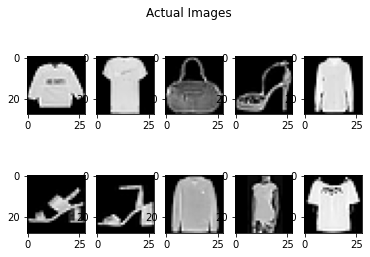

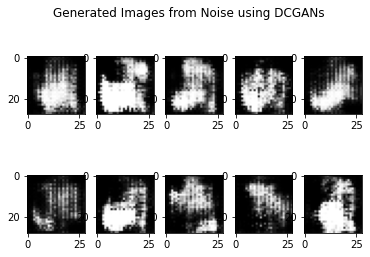

In [50]:
noise = np.random.normal(loc=0, scale=1, size=(100, 100))
gen_image = gen_model.predict(noise)

fig,axe = plt.subplots(2,5)
fig.suptitle('Actual Images')
index = 0

for i in range(2):
    for j in range(5):
        axe[i,j].imshow(x_train[index].reshape(28, 28), cmap='gray')
        index += 10
        
fig,axe = plt.subplots(2, 5)
fig.suptitle('Generated Images from Noise using DCGANs')
index = 0

# Looks horrible because of the reduced filter size.
# It is supposed to look as close as the actual images.
# Had to reduce filter size becaues running on local PC and took too long
for i in range(2):
     for j in range(5):
        axe[i,j].imshow(gen_image[index].reshape(28, 28), cmap='gray')
        index += 3